## 인공지능으로 세상에 없던 새로운 이미지 만들기

개발 환경
<br/>데이터 정보
<br/>데이터 탐색

모델 구성
<br/>Generator
<br/>Discriminator
<br/>Loss Function
<br/>Optimizer
<br/>Decorator

모델 학습
<br/>모델 평가
<br/>결론
<br/>참고문헌

# 개발 환경

In [ ]:
pip install imageio

In [ ]:
import os
import logging
import glob
import time

In [ ]:
import PIL
import imageio
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['glob', 'imageio', 'display', 'Pillow' 'numpy=', 
                'tensorflow=', 'keras','tensorflow.keras', 'matplotlib=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

glob2==0.7      imageio==2.4.1      keras==2.8.0     
keras-vis==0.4.1      matplotlib==3.2.2      tensorflow==2.8.2+zzzcolab20220527125636     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보

[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html)

CIFAR-10 데이터셋은 32x32 픽셀의 컬러 이미지 60000장으로 구성된다.
<br/>airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck이라는
<br/>각 분류마다 6000장이 구성된다.
<br/>훈련 데이터 50000장, 평가 데이터 10000장으로 분리된다.

#데이터 탐색

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (_, _) = cifar10.load_data()

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
train_x = (train_x - 127.5) / 127.5 

학습에 사용할 train_x의 이미지를 -1, 1로 정규화한다.

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

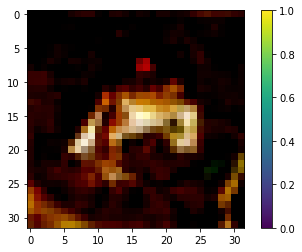

In [ ]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

plt.imshow(train_x[0])
plt.colorbar()
plt.show()

logger.setLevel(old_level)

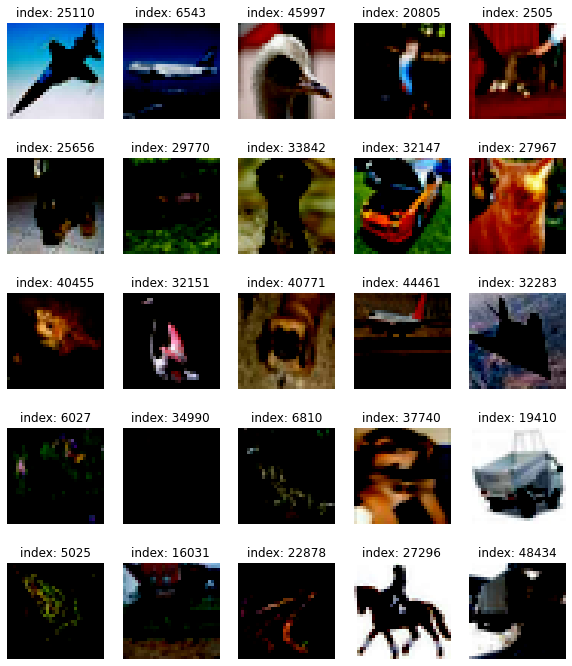

In [ ]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 49999)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

logger.setLevel(old_level)

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tf.data.Dataset의 from_tensor_slices로 미니배치 데이터셋을 구성한다.

#모델 구성

##Generator

In [ ]:
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

(32, 32, 3)의 shape를 가진 CIFAR10의 Generator는 Dense Layer과 Reshape Layer는 (8, 8, 256)으로 구성된다.
<br/>5층의 Conv2DTranspose Layer를 구성하고 뒤에 Batch Normalization과 Leaky ReLU Layer를 더한다.

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        2097152   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2

In [ ]:
noise = tf.random.normal([1, 100])

noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 
<br/>이전에 구현한 Generator로 랜덤 이미지를 생성한다.

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

랜덤 이미지가 Generator 출력 규격에 잘 맞는지 확인한다.

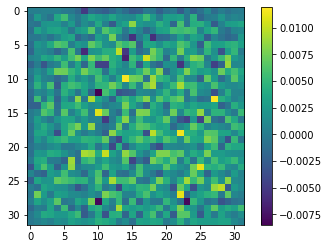

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

##Discriminator

In [ ]:
def make_discriminator_model():

    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    model.add(layers.Flatten())

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Generator로 만든 랜덤 이미지를 Discriminator가 판별한 결과를 확인한다.

(32, 32, 3)의 shape를 가진 CIFAR10의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 Discriminator를 정의한다.
<br/>4층의 Conv2 Layer를 구성하고 뒤에 Leaky ReLU Layer과 Dropout를 더한다.
<br/>마지막에 Flatten Layer, Dense Layer를 더한다. 

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49993145]], dtype=float32)>

##Loss Function

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator와 Discriminator의 손실함수를 정의한다.

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

Discriminator의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현한다.

##Optimizer

In [ ]:
learning_rate = 2e-4 
beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1, amsgrad=True)

Generator와 Discriminator를 최적화하는 optimizer를 정의한다.

In [ ]:
noise_dim = 100
num_examples_to_generate = 16
tf.random.set_seed(1234)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

샘플은 한 번에 16장을 생성한다.
<br/>샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로
<br/>고정된 seed 노이즈를 만든다.
<br/>즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만든다.

##Decorator

In [ ]:
@tf.function
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) 

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 정의한다.

def train_step(images)는 입력데이터를 다룬다.
<br/>Real Image 역할을 할 images 한 세트를 입력으로 받는다.

noise = tf.random.normal([BATCH_SIZE, noise_dim])는 생성자 입력 노이즈를 다룬다.
<br/>Generator가 FAKE IMAGE를 생성하기 위한 noise를
<br/>images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성한다.


with tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문을 연다.

generated_images는 Generator가 noise를 입력받은 후 generated_images를 생성한다.

fake_output, real_output으로 Generator와 Discriminator 각각의 loss를 계산하고
<br/>Discriminator의 정확도를 계산한다.

gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산한다.

generator_optimizer, discriminator_optimizer에서
<br/>계산된 gradient를 optimizer에 입력해 가중치 갱신하며 모델을 학습한다.

In [ ]:
os.environ['home'] = '/content'

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/drive/MyDrive/lms/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('home'), epoch, it))

    plt.show()

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는
<br/> generate_and_save_images() 함수를 정의한다.

In [ ]:
rcParams['figure.figsize'] = 15, 6    

def draw_train_history(history, epoch):
    
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    plt.savefig('{}/drive/MyDrive/lms/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('home'), epoch))
    plt.show()

훈련 epoch마다 Generator/Discriminator의 loss
<br/>Discriminator의 실제/생성(real/fake) 이미지 판별 accuracy history를
<br/>그래프로 시각화하는 draw_train_history() 함수를 정의한다.

training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장한다.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/lms/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정한다.

#모델 학습

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 500

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

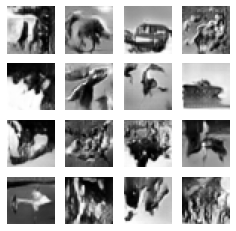

Time for training : 21996 sec


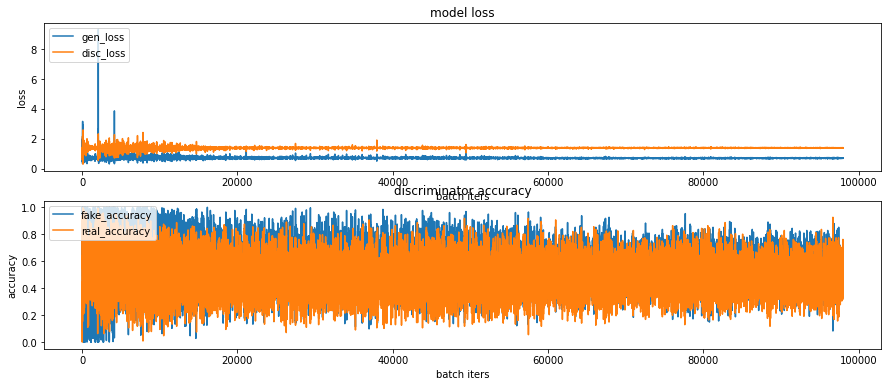

CPU times: user 6h 9min 3s, sys: 4min, total: 6h 13min 4s
Wall time: 6h 6min 41s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현한다.

#모델 평가

In [ ]:
anim_file = '/content/drive/MyDrive/lms/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/drive/MyDrive/lms/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('home')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/lms/dcgan_newimage/cifar10/cifar10_dcgan.gif

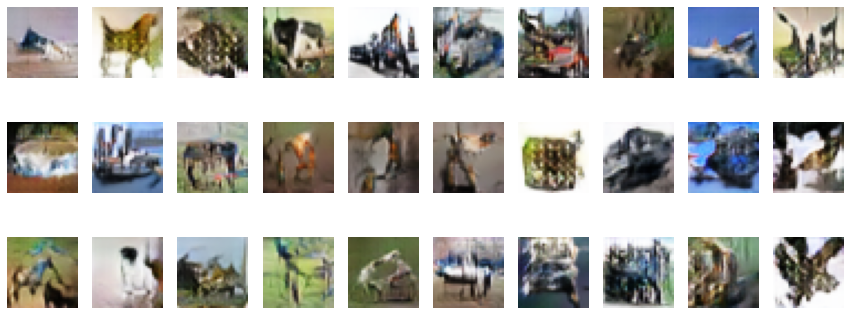

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/lms/cifar10/dcgan_newimage/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

for i in range(30):
    plt.subplot(3, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5  
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()   

모델이 정상적으로 이미지를 생성하는지 확인한다. 
<br/>랜덤 이미지가 아니라 CIFAR-10 이미지가 그려지면 모델의 성능이 뛰어난 것이다.

#결론

<img src="https://github.com/minseok0809/aiffel-ai-project/blob/main/ai-study/output/cifar10_dcgan.gif?raw=true" width="300" height="300" >

<img src="https://github.com/minseok0809/aiffel-ai-project/blob/main/ai-study/output/dcgan_train_history_0499.png?raw=true" width="1000" height="500" >

#참고문헌

**공식 사이트**
<br/>[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html)

<br/>**깃허브**
<br/>[create_CIFAR_10_fake_images.ipynb](https://github.com/HRPzz/AIFFEL/blob/main/EXPLORATION/Node_10/%5BE-10%5D%20create_CIFAR_10_fake_images.ipynb)

<br/>**웹사이트**
<br/>[Disable MatPlotLib warning when using pyplot.imshow](https://stackoverflow.com/questions/54848310/disable-matplotlib-warning-when-using-pyplot-imshow)
<br/>[Part 2 인공지능으로 새로운 패션을 만들 수 있다!](https://zzcojoa.tistory.com/86)